In [397]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn import metrics
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

START_TOKEN = "<START>"
STOP_TOKEN = "<STOP>"
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"

SPECIAL_TOKENS = [START_TOKEN, STOP_TOKEN, PAD_TOKEN]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

train_df = pd.read_csv("hw_3_train_data.csv")

using cuda


In [326]:
def tokenize(corpus, callback=lambda sent: sent.split()):
    return [[START_TOKEN] + callback(sent) + [STOP_TOKEN] for sent in corpus]


def padding(corpus, seq_len):
    for sent in corpus:
        while len(sent) < seq_len:
            sent.append(PAD_TOKEN)
        while len(sent) > seq_len:
            sent.pop()
    return corpus


def build_vocab(corpus):
    vocab = set()
    for sent in corpus:
        vocab.update(set(sent))
    vocab = list(vocab) + [UNK_TOKEN]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    return vocab, word2idx, idx2word


def convert_to_idx(corpus, word2idx):
    return [[word2idx.get(word, "<UNK>") for word in sent] for sent in corpus]

In [332]:
# Data Preprocessing
# Create Dataset class
class UtteranceSlotDataset(Dataset):
    def __init__(self, utterances, slots, seq_len=None):
        # tokenization(including adding special tokens)
        utterances = tokenize(utterances)
        slots = tokenize(slots)

        # padding
        self.seq_len = seq_len
        if not seq_len:
            self.seq_len = len(max(utterances, key=lambda sent: len(sent)))
        utterances = padding(utterances, self.seq_len)
        slots = padding(slots, self.seq_len)

        # get vocab for both utterance and slot
        self.vocab, self.word2idx, self.idx2word = build_vocab(utterances)
        self.slot_list, self.slot2idx, self.idx2slot = build_vocab(slots)

        # convert to index space
        utterances = convert_to_idx(utterances, self.word2idx)
        slots = convert_to_idx(slots, self.slot2idx)

        # Convert arrays to torch tensors
        self.X = torch.tensor(utterances).to(device)
        self.y = torch.tensor(slots).to(device)

    # Must have
    def __len__(self):
        return len(self.y)

    # Must have
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [99]:
train_utterances = list(train_df["utterances"])
train_slots = list(train_df["IOB Slot tags"])
utterance_slot_dataset = UtteranceSlotDataset(train_utterances, train_slots)
utterance_slot_dataset.X.shape, utterance_slot_dataset.y.shape

(torch.Size([2253, 23]), torch.Size([2253, 23]))

In [100]:
val_len = int(len(utterance_slot_dataset) * 0.3)
train_set, val_set = random_split(
    utterance_slot_dataset, [len(utterance_slot_dataset) - val_len, val_len]
)

In [209]:
# functions for creating the embedding layer


def get_one_hot_matrix(vocab):
    one_hot_matrix = np.zeros((len(vocab), len(vocab)))
    np.fill_diagonal(one_hot_matrix, 1)
    return one_hot_matrix


def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({"weight": torch.tensor(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [248]:
# The baseline model using RNN and one-hot encoding
class BaselineModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        seq_len,
        emb_layer,
    ):
        super(BaselineModel, self).__init__()
        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.seq_len = seq_len

        # Defining the layers
        # Embedding Layer
        self.emb_layer = emb_layer
        # RNN Layer
        self.rnn = nn.RNNCell(input_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.emb_layer(x)

        hiddens = []

        # Initializing hidden state for first input
        hidden = torch.zeros(batch_size, self.output_size).to(device)

        for t in range(self.seq_len):
            hidden = self.rnn(out[:, t, :], hidden)
            # make an additional dimension
            hiddens.append(torch.unsqueeze(hidden, dim=2))

        # concat all the hidden layer
        hiddens = torch.cat(hiddens, dim=2)
        out = F.softmax(hiddens, dim=1)
        return out

In [291]:
# Evaluation
def evaluate(true, pred, output_dict=False):
    gold = [slot for sequence in true for slot in sequence]
    pred = [slot for sequence in pred for slot in sequence]
    return metrics.classification_report(
        gold, pred, output_dict=output_dict, zero_division=0
    )


def inference(model, val_X):
    val_pred = model(val_X)
    val_pred = torch.argmax(val_pred, dim=1)
    return val_pred


def val_accuracy(model, val_X, val_y):
    val_X = utterance_slot_dataset.X[val_set.indices]
    val_y = utterance_slot_dataset.y[val_set.indices]

    val_pred = inference(model, val_X)

    input_seqs = convert_to_token(
        val_X.tolist(), utterance_slot_dataset.idx2word
    )
    preds = convert_to_token(
        val_pred.tolist(), utterance_slot_dataset.idx2slot
    )
    trues = convert_to_token(val_y.tolist(), utterance_slot_dataset.idx2slot)

    input_seqs, preds, trues = process_output_corpus(input_seqs, preds, trues)

    return evaluate(trues, preds, output_dict=True)["accuracy"]

In [292]:
# Output Processing
def process_output_corpus(input_seqs, preds, trues):
    new_seqs = []
    new_preds = []
    new_trues = []
    for i in range(len(input_seqs)):
        new_seq, new_pred, new_true = remove_special_tokens(
            input_seqs[i], preds[i], trues[i]
        )
        new_seqs.append(new_seq)
        new_preds.append(new_pred)
        new_trues.append(new_true)
    return new_seqs, new_preds, new_trues


def remove_special_tokens(input_seq, pred, true):
    new_seq = []
    new_pred = []
    new_true = []
    for i in range(len(input_seq)):
        if input_seq[i] in SPECIAL_TOKENS:
            continue
        new_seq.append(input_seq[i])
        new_pred.append(pred[i])
        new_true.append(true[i])

    return new_seq, new_pred, new_true


def convert_to_token(corpus, idx2token):
    return [[idx2token[token_idx] for token_idx in sent] for sent in corpus]

In [313]:
# Define hyperparameters

## Model
num_classes = len(utterance_slot_dataset.slot2idx)
seq_len = utterance_slot_dataset.seq_len

## Training
batch_size = 2048


train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
)

all_train_loader = DataLoader(
    dataset=utterance_slot_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [315]:
def train(model, n_epochs, data_loader, loss_func, optimizer, is_plot=False):
    epochs_plot = []
    losses_plot = []

    for epoch in range(1, n_epochs + 1):

        for batch_idx, (x, true_y) in enumerate(data_loader):
            # reset grads in the optimizer
            optimizer.zero_grad()
            # make prediction
            pred_y = model(x)
            # calculate the loss
            loss = loss_func(pred_y, true_y)
            # back propagation
            loss.backward()
            # perform optimization step
            optimizer.step()
        # perform evaluation on val set every 10 epochs
        if epoch % 10 == 0:
            print(f"{epoch}/{n_epochs}:", end="\t")
            print(
                "val accuracy: ", val_accuracy(model, val_X, val_y), end="\t"
            )
            print("loss: ", loss.item())
            if is_plot:
                epochs_plot.append(epoch)
                losses_plot.append(loss.item())
    if is_plot:
        # a figure with 2x1 grid of Axes
        fig, ax = plt.subplots(figsize=(10, 10))

        ax.set_xlabel("Epoch")
        ax.set_ylabel("Cross Entropy Loss")
        ax.set_title("Baseline Performance")
        _ = ax.plot(epochs_plot, losses_plot)

10/2000:	val accuracy:  0.005103224309904894	loss:  3.4294795989990234
20/2000:	val accuracy:  0.014845743446996056	loss:  3.4268524646759033
30/2000:	val accuracy:  0.055671537926235214	loss:  3.4240169525146484
40/2000:	val accuracy:  0.17629320343307817	loss:  3.4209911823272705
50/2000:	val accuracy:  0.2881002087682672	loss:  3.4178006649017334
60/2000:	val accuracy:  0.4398051496172582	loss:  3.414515972137451
70/2000:	val accuracy:  0.5673857573648805	loss:  3.411208391189575
80/2000:	val accuracy:  0.6664347019253074	loss:  3.407972812652588
90/2000:	val accuracy:  0.7397355601948504	loss:  3.404872179031372
100/2000:	val accuracy:  0.7726745534678728	loss:  3.4019548892974854
110/2000:	val accuracy:  0.7870563674321504	loss:  3.3992297649383545
120/2000:	val accuracy:  0.8028299698445837	loss:  3.3966832160949707
130/2000:	val accuracy:  0.8146601716539086	loss:  3.3942830562591553
140/2000:	val accuracy:  0.8274182324286709	loss:  3.391998767852783
150/2000:	val accuracy:  0.

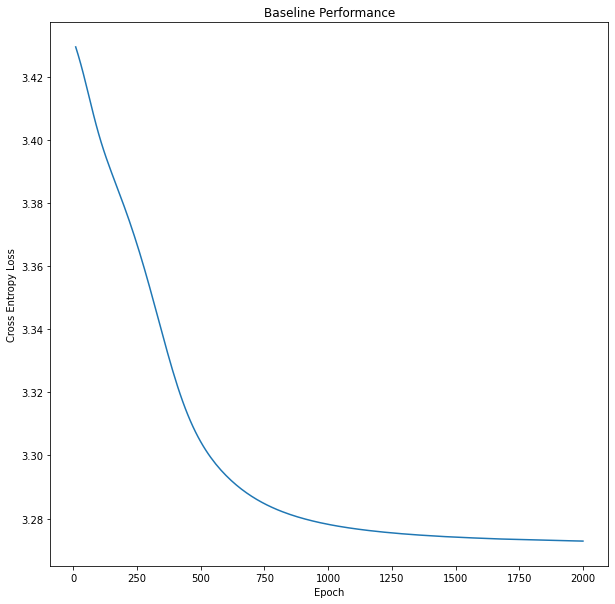

In [316]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

val_model = BaselineModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
train(
    model=val_model,
    n_epochs=2000,
    data_loader=train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(val_model.parameters(), lr=0.00005),
    is_plot=True,
)

10/500:	val accuracy:  0.016005567153792623	loss:  3.4383933544158936
20/500:	val accuracy:  0.025516121549524474	loss:  3.433744430541992
30/500:	val accuracy:  0.05799118533982835	loss:  3.427293539047241
40/500:	val accuracy:  0.19670610067269775	loss:  3.418682336807251
50/500:	val accuracy:  0.402690790999768	loss:  3.409611225128174
60/500:	val accuracy:  0.6687543493389004	loss:  3.401313543319702
70/500:	val accuracy:  0.7921595917420552	loss:  3.394371747970581
80/500:	val accuracy:  0.8362328926003247	loss:  3.388357162475586
90/500:	val accuracy:  0.8496868475991649	loss:  3.3832168579101562
100/500:	val accuracy:  0.8617490141498492	loss:  3.37754225730896
110/500:	val accuracy:  0.8731152864764555	loss:  3.372821092605591
120/500:	val accuracy:  0.8828578056135468	loss:  3.3678033351898193
130/500:	val accuracy:  0.891208536302482	loss:  3.3627536296844482
140/500:	val accuracy:  0.8970076548364648	loss:  3.3576388359069824
150/500:	val accuracy:  0.9028067733704477	loss: 

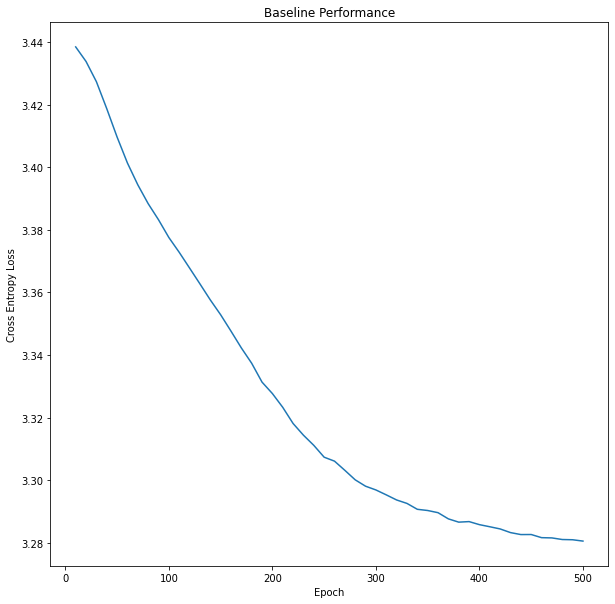

In [318]:
# create the embedding layer
one_hot_emb_layer, num_embeddings, embedding_dim = create_emb_layer(
    get_one_hot_matrix(utterance_slot_dataset.vocab)
)

test_model = BaselineModel(
    input_size=embedding_dim,
    output_size=num_classes,
    seq_len=seq_len,
    emb_layer=one_hot_emb_layer,
).to(device)
train(
    model=test_model,
    n_epochs=500,
    data_loader=all_train_loader,
    loss_func=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(test_model.parameters(), lr=0.00005),
    is_plot=True,
)

In [319]:
test_df = pd.read_csv("test_data.csv")

In [371]:
test_utterances = list(test_df["utterances"])

In [372]:
def preprocess_utterances(utterances, utterance_dataset):
    # tokenization
    utterances = tokenize(utterances)
    # padding
    utterances = padding(tokenized_utterances, utterance_dataset.seq_len)

    word2idx = utterance_dataset.word2idx
    utterances = [
        [word2idx.get(token, word2idx[UNK_TOKEN]) for token in sent]
        for sent in utterances
    ]

    return utterances

In [400]:
test_X = torch.tensor(
    preprocess_utterances(test_utterances, utterance_slot_dataset)
).to(device)

In [401]:
test_pred = inference(test_model, test_X)

In [402]:
input_seqs = convert_to_token(test_X.tolist(), utterance_slot_dataset.idx2word)
preds = convert_to_token(test_pred.tolist(), utterance_slot_dataset.idx2slot)
input_seqs, preds, _ = process_output_corpus(input_seqs, preds, preds)

In [403]:
for i, sent in enumerate(input_seqs):
    if len(sent) != len(test_utterances[i].split()):
        print(sent, test_utterances[i])

In [404]:
for pred in preds:
    for i, slot in enumerate(pred):
        if slot in SPECIAL_TOKENS:
            pred[i] = "O"

In [405]:
all_slots = [slot for seq in preds for slot in seq]

In [406]:
indexes = list(range(len(all_slots)))

In [407]:
output_df = pd.DataFrame({"Id": indexes, "Predicted": all_slots})

In [408]:
output_df.to_csv("baseline.csv", index=False)